# Groupes de passagers sur le Titanic

L'objectif de ce TD est d'explorer et d'identifier les grandes catégories de passagers présents à bord du Titanic.

Comme souvent en partitionnement, les groupes seront formés arbitrairement, et il est possible de réaliser une analyse sur ces groupes pour identifier des tendances.  
Il est également envisageable de viser à reconstituer des groupes pour lesquels la vérité de terrain est connue (par exemple la classe, la nationalité, etc.).

Ce TD sera basé en grande partie sur la (re-)découverte des classes de passagers.

## Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import set_config

set_config(transform_output="pandas")

In [2]:
passengers = pd.read_csv("passengers.csv", parse_dates=["birthday"])

### Génération du nombre de passagers par billet et du prix unitaire

In [3]:
cnts = passengers.groupby(["ticket", "fare"])["survived"].count().rename("co-travelers").reset_index()
passengers = passengers.merge(cnts, on=["ticket", "fare"])
passengers["unit fare"] = passengers["fare"] / passengers["co-travelers"]
passengers

,class,survived,title,surname,first name,sex,age,birthday,nationality,sibsp,parch,ticket,fare,cabin,boarded,lifeboat,body,home.dest,co-travelers,unit fare
0,1,1,Miss,Cherry,Gladys,female,30.0,1881-08-27,English,0,0,110152,86.500,B77,S,8,NaN,"London, England",3,28.833333
1,1,1,Miss,Maioni,Roberta,female,20.0,NaT,English,0,0,110152,86.500,B79,S,8,NaN,NaN,3,28.833333
2,1,1,Countess,Rothes (of),(Lucy Noel Martha Dyer-Edwards),female,33.0,1878-12-25,Scottish,0,0,110152,86.500,B77,S,8,NaN,"London Vancouver, BC",3,28.833333
3,1,0,Mr.,Taussig,Emil,male,52.0,NaT,American,1,1,110413,79.650,E67,S,NaN,NaN,"New York, NY",3,26.550000
4,1,1,Mrs.,Taussig,Emil (Tillie Mandelbaum),female,39.0,1872-12-18,American,1,1,110413,79.650,E67,S,8,NaN,"New York, NY",3,26.550000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1312,3,0,Mrs.,Ford,Edward (Margaret Ann Watson),female,48.0,NaT,English,1,3,W/C 6608,34.375,NaN,S,NaN,NaN,"Rotherfield, Sussex, England Essex Co, MA",5,6.875000
1313,3,0,Mr.,Ford,Edward Watson,male,18.0,NaT,English,2,2,W/C 6608,34.375,NaN,S,NaN,NaN,"Rotherfield, Sussex, England Essex Co, MA",5,6.875000
1314,3,0,Miss,Ford,"Robina Maggie ""Ruby""",female,7.0,1904-04-25,English,2,2,W/C 6608,34.375,NaN,S,NaN,NaN,"Rotherfield, Sussex, England Essex Co, MA",5,6.875000
1315,3,0,Mr.,Ford,William Neal,male,16.0,NaT,English,1,3,W/C 6608,34.375,NaN,S,NaN,NaN,"Rotherfield, Sussex, England Essex Co, MA",5,6.875000


**Q1.1** Visualiser les variations des politiques tarifaires, globalement puis par classe.  
Suggestion : utiliser la fonction [`relplot`](https://seaborn.pydata.org/generated/seaborn.relplot.html) de la bibliothèque seaborn, avec :

- en ordonnée le prix unitaire,
- en abscisse le nombre de personnes concernées par le billet,
- en colonne la classe (optionnellement).

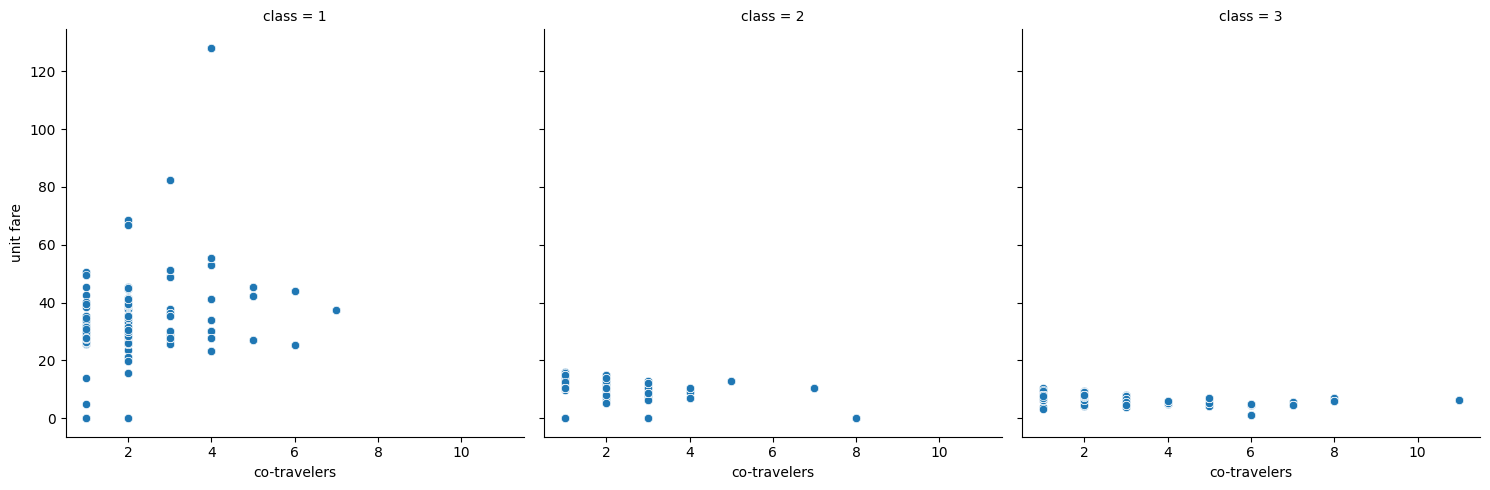

In [4]:
sns.relplot(data=passengers, y="unit fare", x="co-travelers", col="class")

**Q1.2** Générer un premier partitionnement avec l'algorithme des K-moyennes (K-means).

In [5]:
from sklearn.cluster import KMeans

In [6]:
kmeans = KMeans(n_clusters=3, n_init=10)
cols = ["unit fare", "co-travelers"]
labels = kmeans.fit_predict(passengers[cols])
labels

array([1, 1, 1, ..., 0, 0, 0], dtype=int32)

**Q1.3** Visualiser la matrice de contingence, puis calculer l'indice de Rand (ajusté ou non) et le taux de bonne classification.  
Pour le calcul du taux de bonne classification, vous pourrez vous baser sur la fonction d'optimisation [`linear_sum_assignment`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.linear_sum_assignment.html) de SciPy.  
Interpréter les résultats obtenus.

In [7]:
from sklearn.metrics import rand_score, adjusted_rand_score
from sklearn.metrics.cluster import contingency_matrix
from scipy.optimize import linear_sum_assignment # équivalent de l'algorithme Hongrois

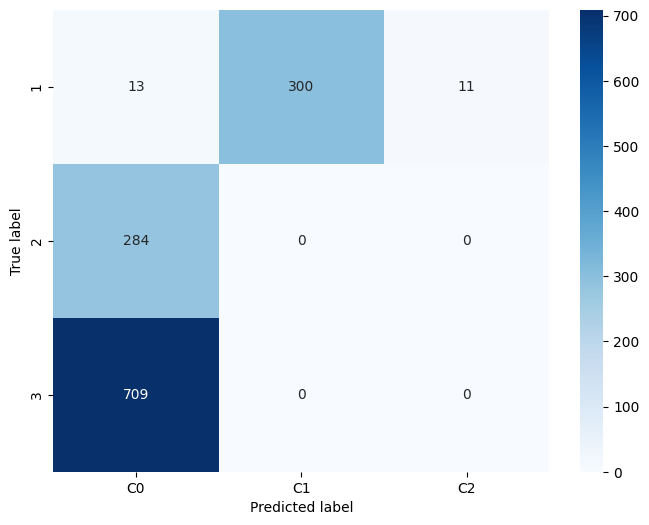

In [8]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(contingency_matrix(passengers["class"], labels), cmap="Blues", yticklabels=[1, 2, 3], xticklabels=["C0", "C1", "C2"], annot=True, fmt="d", ax=ax)
ax.set_ylabel("True label")
ax.set_xlabel("Predicted label")
plt.show()

In [9]:
print(f"Rand score: {rand_score(passengers['class'], labels)}")
print(f"Adjusted rand score: {adjusted_rand_score(passengers['class'], labels)}")
m = contingency_matrix(passengers['class'], labels)
accuracy = m[linear_sum_assignment(m, maximize=True)].sum()/m.sum()
print(f"Accuracy (best assignment): {accuracy}")

Rand score: 0.7442746594106067
Adjusted rand score: 0.5156810373016474
Accuracy (best assignment): 0.7661351556567958


**Q1.4** Afficher, sur le même type de graphique que celui utilisé pour visualiser les variations tarifaires, les groupes générés par K-means (par un code couleur par exemple).

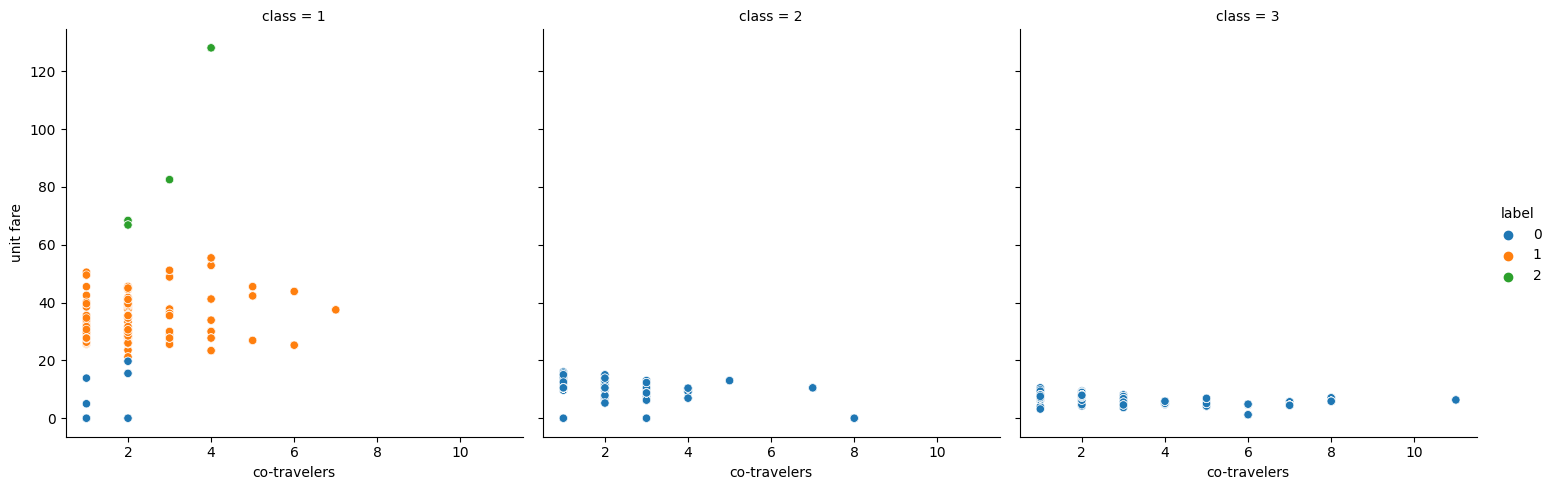

In [10]:
passengers["label"] = labels
sns.relplot(data=passengers, y="unit fare", x="co-travelers", col='class', hue="label", palette="tab10")

**Q1.5** Calculer le score de silhouette de chaque échantillon par rapport aux partitions données par K-means.  
Visualiser la distribution des valeurs des scores par partition.  
Visualiser, sur le plan de projection des valeurs originales (co-travelers, unit fare), la valeur de la silhouette pour chaque point (par une couleur par exemple).

In [11]:
from sklearn.metrics import silhouette_samples

<AxesSubplot:xlabel='label', ylabel='silhouette'>

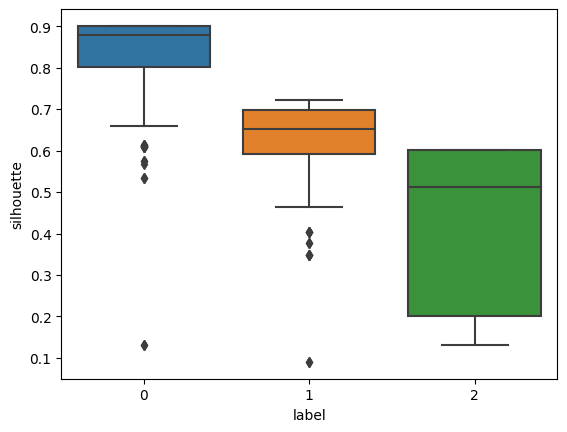

In [12]:
passengers["silhouette"] = silhouette_samples(passengers[cols], passengers["label"])
sns.boxplot(passengers, x="label", y="silhouette")

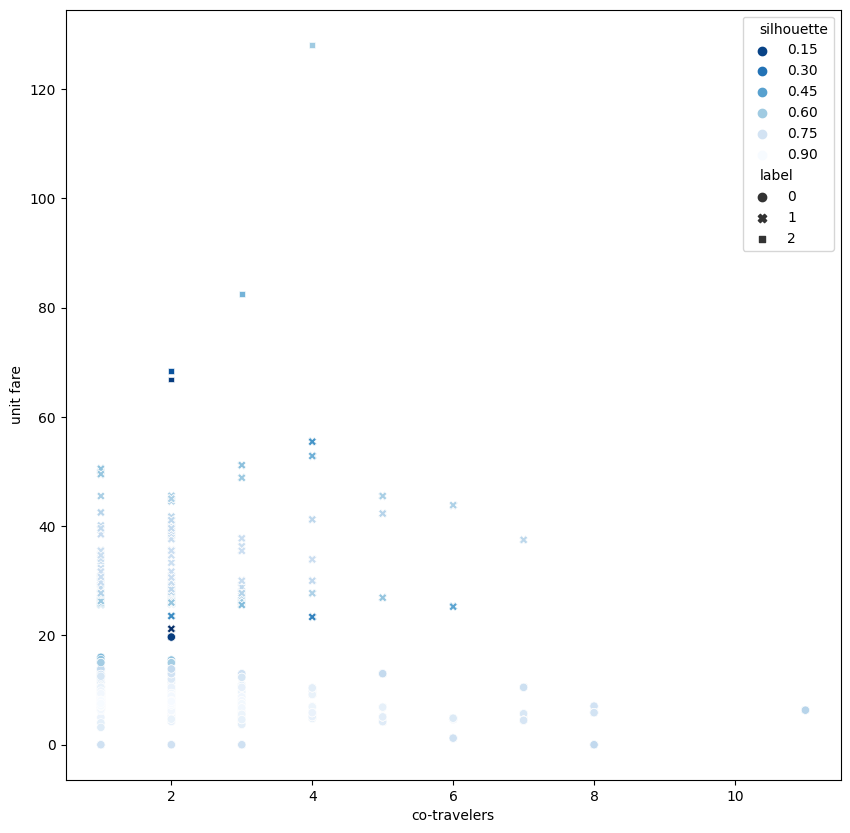

In [13]:
fig = plt.figure(figsize=(10, 10))
sns.scatterplot(data=passengers, y="unit fare", x="co-travelers", hue="silhouette", style="label", palette="Blues_r")
plt.show()

**Q1.6** Reprendre la question précédente, mais en calculant cette fois le score de silhouette sur la base du résultat attendu (la classe réelle des passagers).  
Que pouvez-vous en conclure ?

<AxesSubplot:xlabel='class', ylabel='silhouette_true'>

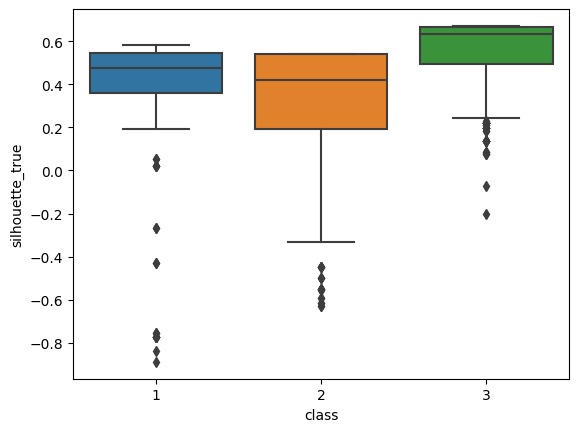

In [14]:
passengers["silhouette_true"] = silhouette_samples(passengers[cols], passengers["class"])
sns.boxplot(passengers, x="class", y="silhouette_true")

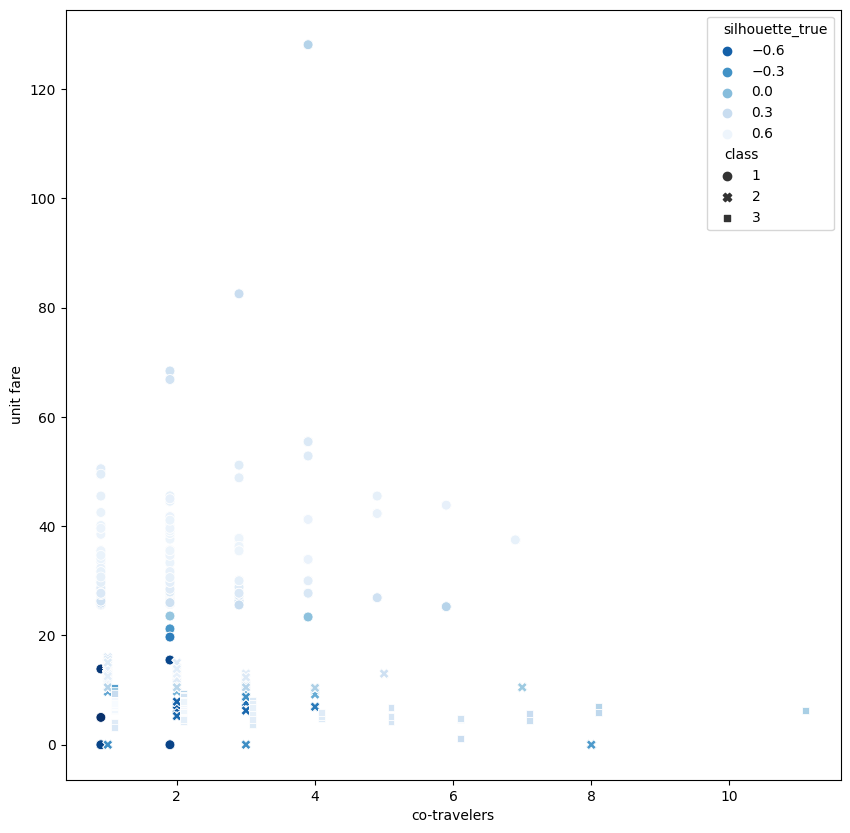

In [15]:
fig = plt.figure(figsize=(10, 10))
passengers_mod = passengers.copy()
passengers_mod["co-travelers"] = passengers_mod["co-travelers"] + (passengers_mod["class"] - 2)*0.1
sns.scatterplot(data=passengers_mod, y="unit fare", x="co-travelers", hue="silhouette_true", style="class", palette="Blues_r", s=50)
plt.show()

# Prétraitements

## Normalisation

**Q2.1** Normaliser le prix unitaire et le nombre de passagers par ticket pour obtenir des valeurs entre 0 et 1.  

In [16]:
from sklearn.preprocessing import MinMaxScaler

In [17]:
kmeans = KMeans(n_clusters=3, n_init=10)
cols = ["unit fare", "co-travelers"]
labels = kmeans.fit_predict(MinMaxScaler().fit_transform(passengers[cols]))

**Q2.2** Cela a-t-il une influence sur la qualité du clustering ?

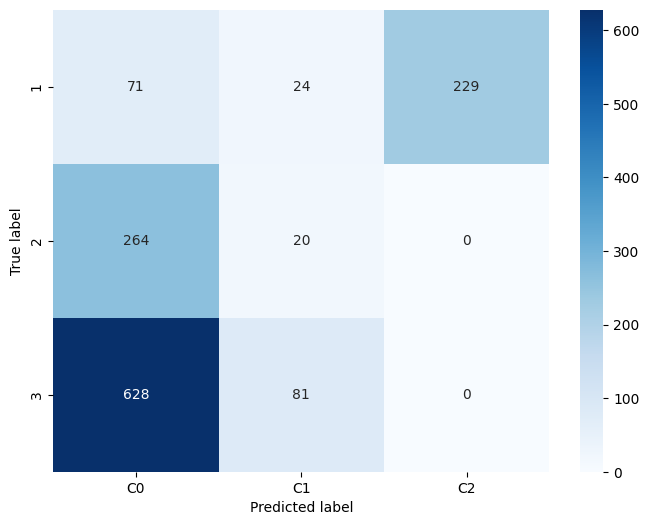

In [18]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(contingency_matrix(passengers["class"], labels), cmap="Blues", yticklabels=[1, 2, 3], xticklabels=["C0", "C1", "C2"], annot=True, fmt="d", ax=ax)
ax.set_ylabel("True label")
ax.set_xlabel("Predicted label")
plt.show()

In [19]:
print(f"Rand score: {rand_score(passengers['class'], labels)}")
print(f"Adjusted rand score: {adjusted_rand_score(passengers['class'], labels)}")
m = contingency_matrix(passengers['class'], labels)
accuracy = m[linear_sum_assignment(m, maximize=True)].sum()/m.sum()
print(f"Accuracy (best assignment): {accuracy}")

Rand score: 0.6390721751793821
Adjusted rand score: 0.29950827288485
Accuracy (best assignment): 0.665907365223994


**Q2.3** Que se passe-t-il si on réalise le clustering uniquement sur la base du prix unitaire ?

In [20]:
kmeans = KMeans(n_clusters=3, n_init=10)
cols = ["unit fare"]
labels = kmeans.fit_predict(passengers[cols])

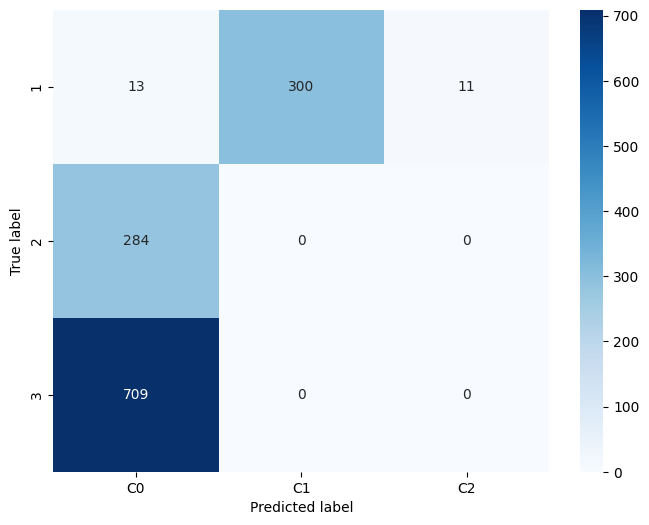

In [21]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(contingency_matrix(passengers["class"], labels), cmap="Blues", yticklabels=[1, 2, 3], xticklabels=["C0", "C1", "C2"], annot=True, fmt="d", ax=ax)
ax.set_ylabel("True label")
ax.set_xlabel("Predicted label")
plt.show()

In [22]:
print(f"Rand score: {rand_score(passengers['class'], labels)}")
print(f"Adjusted rand score: {adjusted_rand_score(passengers['class'], labels)}")
m = contingency_matrix(passengers['class'], labels)
accuracy = m[linear_sum_assignment(m, maximize=True)].sum()/m.sum()
print(f"Accuracy (best assignment): {accuracy}")

Rand score: 0.7442746594106067
Adjusted rand score: 0.5156810373016474
Accuracy (best assignment): 0.7661351556567958


> Les poids inhérents au calcul de la norme euclidienne font que le prix unitaire avait, à l'origine, un poids beaucoup plus important que le nombre de passagers dans la première version du traitement.  
> Et c'est plutôt une bonne chose sur les résultats, car le partitionnement fonctionne aussi bien sans cette information, qui semble en pratique superflue.

# Visualisation pour des données multidimensionnelles

## Analyse en composantes principales

Il peut être difficile de visualiser les données caractérisées par de nombreuses dimensions. Une technique classique consiste à projeter les données dans une espace à deux dimensions (deux axes), de manière à maximiser la dispersion des valeurs sur ces axes.

**Q3.1** Après avoir appliqué K-means sur un ensemble de quatre attributs ou plus, visualiser la partition résultat dans le plan en utilisant une [analyse en composantes principales](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html).

In [23]:
from sklearn.decomposition import PCA

In [24]:
kmeans = KMeans(n_clusters=3, n_init=10)
cols = ["sibsp", "parch", "unit fare", "co-travelers"]
labels = kmeans.fit_predict(passengers[cols])

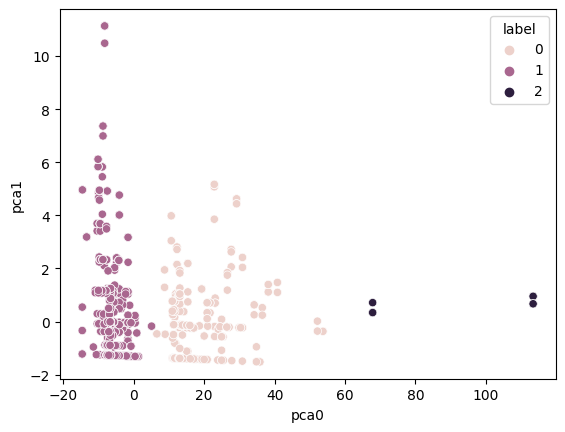

In [25]:
pca = PCA(n_components=2)
X = pca.fit_transform(passengers[cols])
X["label"] = labels
sns.scatterplot(X, x="pca0", y="pca1", hue="label")
plt.show()

In [26]:
pca.components_

array([[-0.00361579, -0.00179376,  0.99995297,  0.00881859],
       [ 0.37502076,  0.2820011 , -0.0059258 ,  0.88306268]])

In [27]:
kmeans = KMeans(n_clusters=3, n_init=10)
cols = ["sibsp", "parch", "unit fare", "co-travelers"]
labels = kmeans.fit_predict(passengers[cols])

> Ou pire...

In [28]:
kmeans = KMeans(n_clusters=3, n_init=10)
X_large = pd.concat([passengers[cols], pd.get_dummies(passengers[['nationality', 'sex', 'title', 'boarded']])], axis=1)
print(f"Raw input has {len(X_large.columns)} features.")
labels = kmeans.fit_predict(X_large)

Raw input has 64 features.


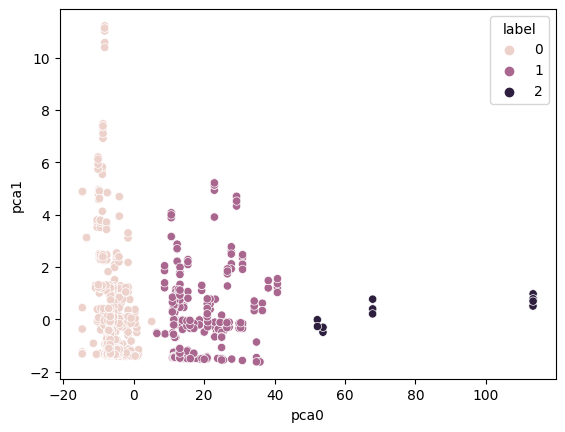

In [29]:
pca = PCA(n_components=2)
X = pca.fit_transform(X_large)
X["label"] = labels
sns.scatterplot(X, x="pca0", y="pca1", hue="label")
plt.show()

> Il faut observer en détail, mais la composition des axes ne semble pas changer fondamentalement.

In [30]:
pca.components_

array([[-3.61146989e-03, -1.78503298e-03,  9.99664786e-01,
         8.82313106e-03,  1.59323212e-02, -1.07335391e-04,
        -4.79884077e-06, -1.48274577e-04, -8.44980819e-04,
        -1.11739491e-04, -8.69160145e-04,  2.46307441e-03,
        -7.27876341e-04, -2.82048708e-04, -6.04570762e-05,
         4.52022422e-05, -5.34939037e-03, -1.62868992e-03,
         9.75077225e-04,  6.06040298e-04, -1.25695973e-04,
        -1.74648177e-05, -3.37791259e-03,  1.03788621e-04,
        -6.86297891e-06, -6.84702931e-06,  5.39984958e-05,
        -8.30197740e-04,  4.68781070e-05, -1.01142900e-04,
        -1.18417523e-04, -3.20529299e-05, -9.01842908e-05,
        -2.03055727e-05,  3.02878469e-04, -3.37186004e-03,
         4.03493347e-04, -2.53654476e-03, -2.14382595e-04,
         2.17365278e-04, -5.45232451e-05,  4.55538859e-03,
        -4.55538859e-03,  8.61194112e-05,  3.20022601e-04,
         5.86279886e-05,  5.39984958e-05,  8.95273289e-05,
         5.26334274e-04,  5.71059403e-05,  1.14565916e-0

> Même si l'analyse en composantes principales fait partie des solutions les plus connues et les plus utilisées, il existe d'autres techniques permettant de projeter des points d'un espace à grande dimensions sur un plan.

In [31]:
from sklearn.manifold import MDS

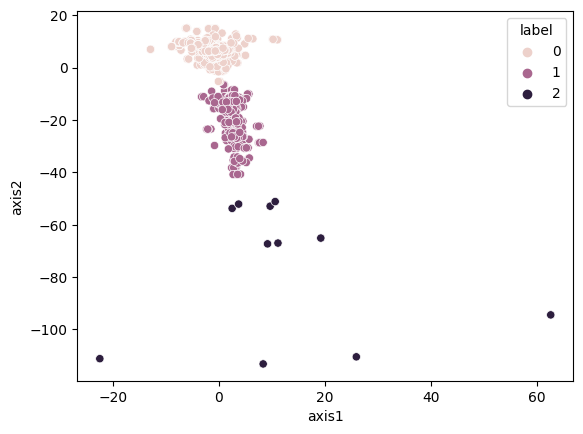

In [32]:
mds = MDS(n_components=2, normalized_stress=False)
X = pd.DataFrame(mds.fit_transform(X_large), columns=["axis1", "axis2"])
X["label"] = labels
sns.scatterplot(X, x="axis1", y="axis2", hue="label")
plt.show()